In [1]:
import pandas as pd

## Load previous queries

In [2]:
df_user = pd.read_csv("retrieval_relevance_evaluations_user_queries.csv")

In [3]:
df_synth = pd.read_csv("retrieval_relevance_evaluations.csv")

In [4]:
user_queries = list(df_user['query'].unique())
synth_queries = list(df_synth['query'].unique())

In [5]:
len(user_queries), len(synth_queries)

(16, 20)

In [6]:
df_user_queries = pd.DataFrame(user_queries, columns=["query"])
df_user_queries['source'] = 'user'

In [7]:
df_synth = pd.DataFrame(synth_queries, columns=["query"])
df_synth['source'] = 'synth'

In [8]:
df_full = pd.concat([df_user_queries, df_synth], ignore_index=True)

## Retrieve top results for each query

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from history_book.database.config import WeaviateConfig
from history_book.database.repositories import BookRepositoryManager

In [11]:
config = WeaviateConfig.from_environment()
repo_manager = BookRepositoryManager(config)

In [12]:
retrieved_para_dict_list = []
# for query in questions_data['questions']:
for n, row in df_full.iterrows():
    query = row['query']
    source = row['source']
    retrieved_paras = repo_manager.paragraphs.similarity_search_by_text(query, limit=100)
    for para, score in retrieved_paras:
        retrieved_para_dict_list.append({"query": query, "text": para.text, "score": score, "source": source})

In [13]:
df_retrieved = pd.DataFrame(retrieved_para_dict_list)

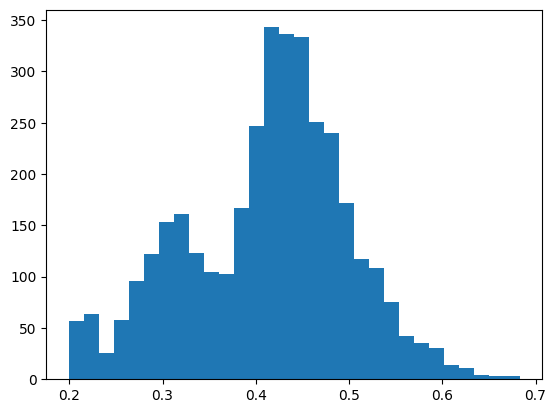

In [14]:
plt.hist(df_retrieved['score'], bins=30)
plt.show()

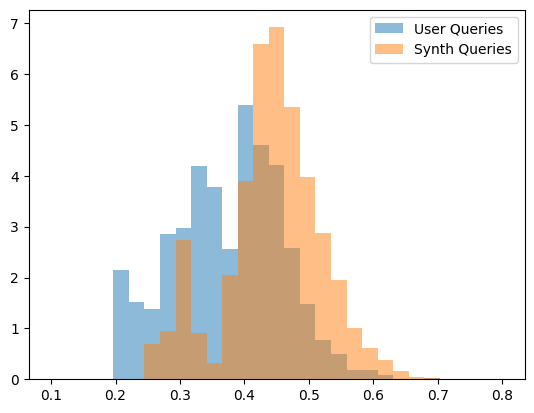

In [15]:
bins = np.linspace(0.1, 0.8, 30)
plt.hist(df_retrieved[df_retrieved['source'] == 'user']['score'], bins=bins, alpha=0.5, label='User Queries', density=True)
plt.hist(df_retrieved[df_retrieved['source'] == 'synth']['score'], bins=bins, alpha=0.5, label='Synth Queries', density=True)
plt.legend()
plt.show()

## Load previous top query results and evals

In [39]:
df_user_query_evals = pd.read_csv("retrieval_relevance_evaluations_user_queries.csv")
df_synth_query_evals = pd.read_csv("retrieval_relevance_evaluations.csv")

In [41]:
df_user_query_evals['source'] = 'user'
df_synth_query_evals['source'] = 'synth'
df_query_evals = pd.concat([df_user_query_evals, df_synth_query_evals], ignore_index=True)

In [43]:
df_query_evals

,query,text,score,is_relevant,reasoning,source
0,What were the first civilizations?,Somewhere in the fourth millennium BC is the s...,0.620501,True,The paragraph provides a chronological overvie...,user
1,What were the first civilizations?,About these first civilizations (whose appeara...,0.594695,True,The paragraph discusses the characteristics an...,user
2,What were the first civilizations?,Mesopotamia was not the only great river valle...,0.593171,True,"The paragraph discusses Mesopotamia and Egypt,...",user
3,What were the first civilizations?,Some of these early civilizations are still re...,0.590554,True,The paragraph discusses early civilizations an...,user
4,What were the first civilizations?,The best case for the first appearance of some...,0.587494,True,The paragraph discusses the emergence of civil...,user
...,...,...,...,...,...,...
3595,What impact did the internet have on global cu...,Some assembly lines nowadays are ‘manned’ enti...,0.409506,False,The paragraph discusses technological changes ...,synth
3596,What impact did the internet have on global cu...,"Such changes are not easily dated, because acc...",0.409291,False,The paragraph discusses the impact of the prin...,synth
3597,What impact did the internet have on global cu...,One change is quickly apparent: in different p...,0.409188,False,The paragraph discusses the differentiation of...,synth
3598,What impact did the internet have on global cu...,This not only brought African-Americans into v...,0.409149,False,The paragraph discusses the struggles and achi...,synth


## Apply reranking

### Cohere

In [82]:
from langchain_cohere import CohereRerank
from langchain.schema import Document
import time

In [49]:

# Initialize reranker
reranker = CohereRerank(
    model="rerank-english-v3.0",
    top_n=100,
)


In [79]:
all_queries = df_query_evals['query'].unique()

In [80]:

len(all_queries)

36

In [81]:
test_query = all_queries[0]
test_query

'What were the first civilizations?'

In [47]:
results_subset = df_query_evals[df_query_evals['query'] == test_query]

In [48]:

# Your already-retrieved documents
retrieved_docs = [
    Document(page_content=row['text']) for _, row in results_subset.iterrows()
]


In [50]:

# Rerank directly
query = test_query
reranked_docs = reranker.compress_documents(
    documents=retrieved_docs,
    query=query
)


In [52]:
df_reranked_subset = pd.DataFrame([{'cohere_score': x.metadata.get('relevance_score'), 'content': x.page_content} for x in reranked_docs])

In [83]:
df_reranked_list = []
for query in all_queries:
    results_subset = df_query_evals[df_query_evals['query'] == query]
    retrieved_docs = [
        Document(page_content=row['text']) for _, row in results_subset.iterrows()
    ]
    reranked_docs = reranker.compress_documents(
        documents=retrieved_docs,
        query=query
    )
    df_reranked_subset = pd.DataFrame([{'query': query, 'cohere_score': x.metadata.get('relevance_score'), 'content': x.page_content} for x in reranked_docs])
    df_reranked_list.append(df_reranked_subset)
    # pause for 10 seconds to avoid rate limiting
    time.sleep(10)
df_reranked = pd.concat(df_reranked_list, ignore_index=True)

In [87]:
df_query_evals_reranked = df_query_evals.merge(df_reranked, left_on=['query', 'text'], right_on=['query', 'content'], how='left').drop(columns=['content'])

### Voyage

## Analsyis

### Single query

In [139]:
query = all_queries[30]
query

'How did the fall of the Berlin Wall in 1989 symbolize the end of the Cold War?'

In [140]:
results_subset = df_query_evals_reranked[df_query_evals_reranked['query'] == query]

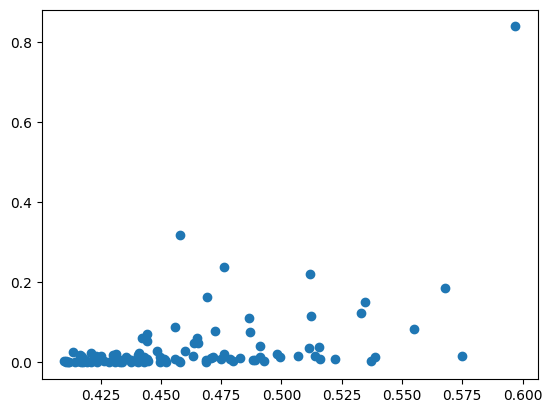

In [141]:
plt.scatter(results_subset['score'], results_subset['cohere_score'])

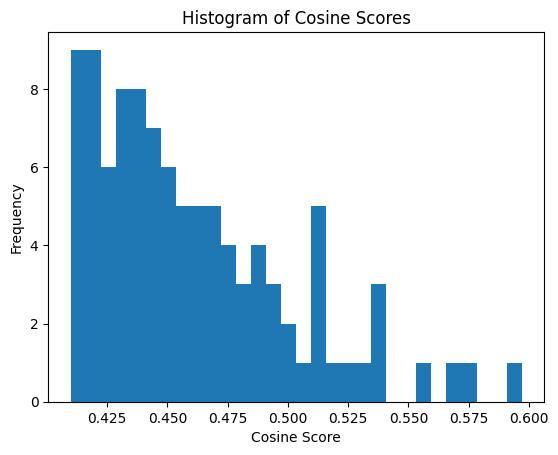

In [142]:
plt.hist(results_subset['score'], bins=30)
plt.title('Histogram of Cosine Scores')
plt.xlabel('Cosine Score')
plt.ylabel('Frequency')
plt.show()

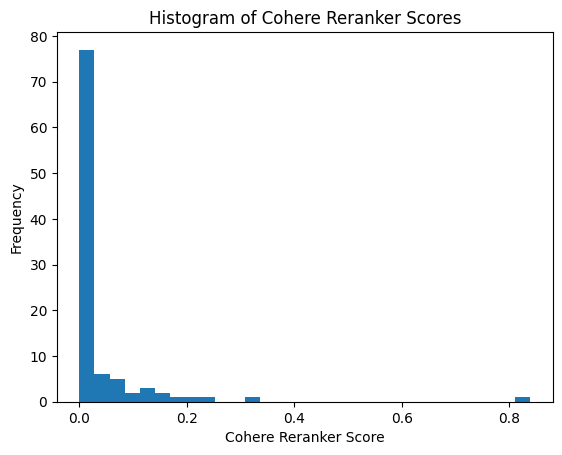

In [143]:
plt.hist(results_subset['cohere_score'], bins=30)
plt.title('Histogram of Cohere Reranker Scores')
plt.xlabel('Cohere Reranker Score')
plt.ylabel('Frequency')
plt.show()

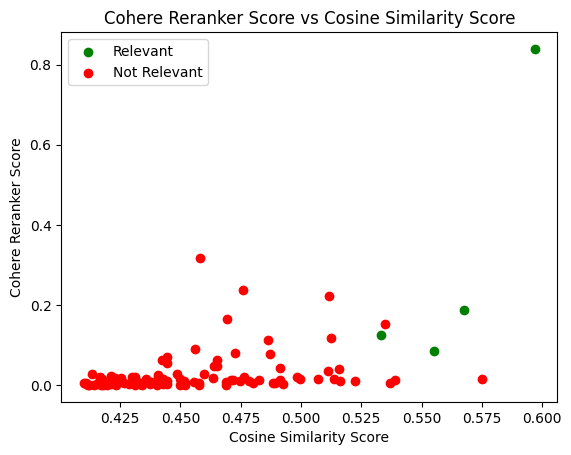

In [144]:
res_is_relevant = results_subset[results_subset['is_relevant']]
res_not_relevant = results_subset[~results_subset['is_relevant']]
plt.scatter(res_is_relevant['score'], res_is_relevant['cohere_score'], color='green', label='Relevant')
plt.scatter(res_not_relevant['score'], res_not_relevant['cohere_score'], color='red', label='Not Relevant')
plt.legend()
plt.title('Cohere Reranker Score vs Cosine Similarity Score')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Cohere Reranker Score')
plt.show()

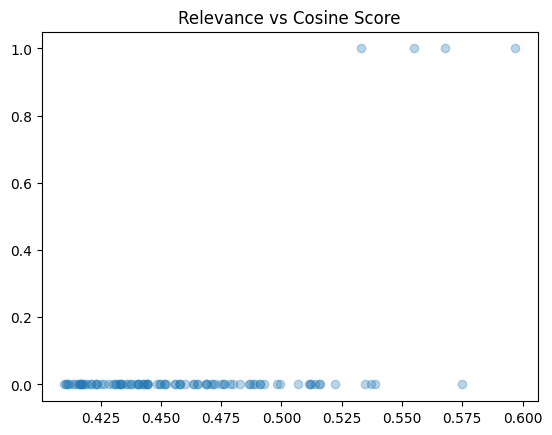

In [145]:
plt.scatter(results_subset['score'], results_subset['is_relevant'], alpha=0.3)
plt.title('Relevance vs Cosine Score')
plt.show()

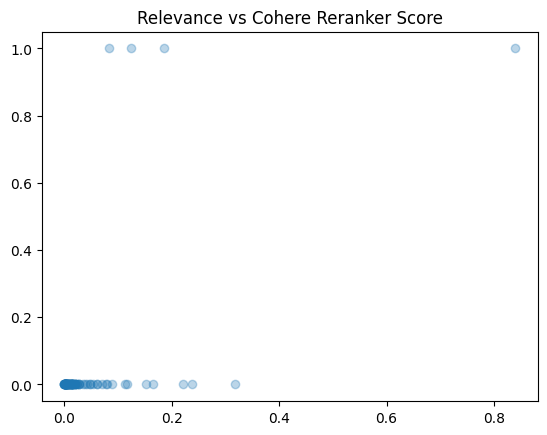

In [146]:
plt.scatter(results_subset['cohere_score'], results_subset['is_relevant'], alpha=0.3)
plt.title('Relevance vs Cohere Reranker Score')
plt.show()

In [147]:
def precision_at_k(df, score_col, relevance_col='is_relevant'):
    precision_values = []
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k)
        precision = df_sorted[relevance_col].mean()
        precision_values.append(precision)
    return precision_values

In [148]:
precision_at_k_values_cosine = precision_at_k(results_subset, 'score')
precision_at_k_values_reranker = precision_at_k(results_subset, 'cohere_score')

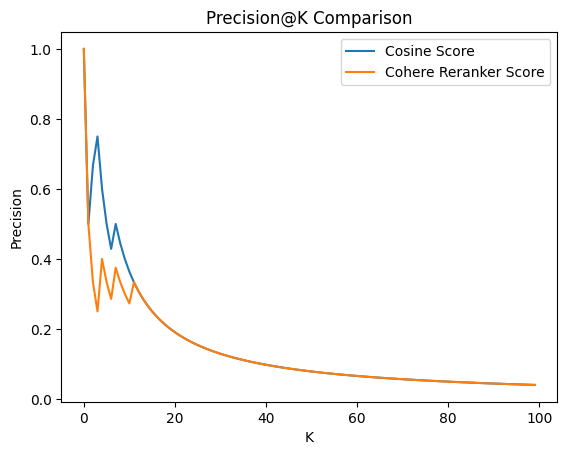

In [149]:
plt.plot(precision_at_k_values_cosine)
plt.plot(precision_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('Precision@K Comparison')
plt.xlabel('K')
plt.ylabel('Precision')
plt.show()

In [150]:
# average precision at k
def ap_at_k(df, score_col, relevance_col='is_relevant'):
    # start with p@k
    precision_values = precision_at_k(df, score_col, relevance_col)
    ap_values = []
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k).reset_index(drop=True)
        relevant_indices = df_sorted.index[df_sorted[relevance_col] == True].tolist()
        if len(relevant_indices) == 0:
            ap_values.append(0)
            continue
        ap = 0
        for idx in relevant_indices:
            ap += precision_values[idx]  # precision at the rank of this relevant document
        ap /= len(relevant_indices)  # average over all relevant documents
        ap_values.append(ap)
    return ap_values    

In [151]:
ap_at_k_values_cosine = ap_at_k(results_subset, 'score')
ap_at_k_values_reranker = ap_at_k(results_subset, 'cohere_score')

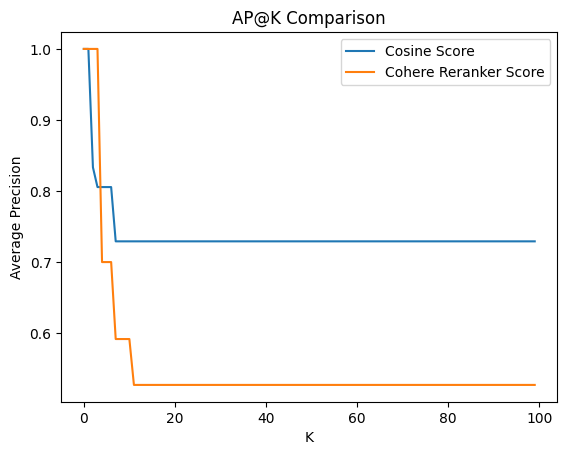

In [152]:
plt.plot(ap_at_k_values_cosine)
plt.plot(ap_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('AP@K Comparison')
plt.xlabel('K')
plt.ylabel('Average Precision')
plt.show()

In [153]:
def recall_at_k(df, score_col, relevance_col='is_relevant'):
    recall_values = []
    total_relevant = df[relevance_col].sum()
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k)
        recall = df_sorted[relevance_col].sum() / total_relevant if total_relevant > 0 else 0
        recall_values.append(recall)
    return recall_values

In [154]:
recall_at_k_values_cosine = recall_at_k(results_subset, 'score')
recall_at_k_values_reranker = recall_at_k(results_subset, 'cohere_score')

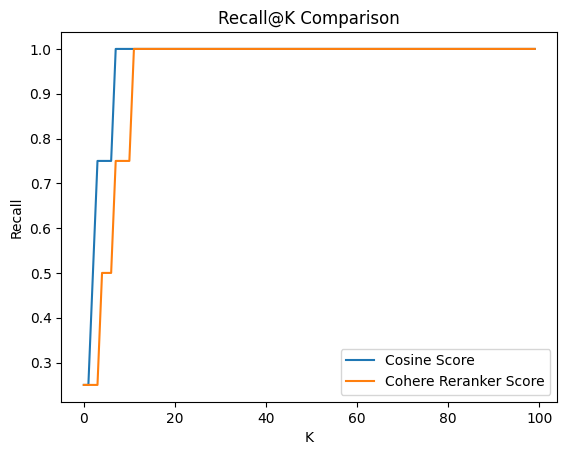

In [155]:
plt.plot(recall_at_k_values_cosine)
plt.plot(recall_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('Recall@K Comparison')
plt.xlabel('K')
plt.ylabel('Recall')
plt.show()

In [156]:
# average recall at k
def ar_at_k(df, score_col, relevance_col='is_relevant'):
    # start with r@k
    recall_values = recall_at_k(df, score_col, relevance_col)
    ar_values = []
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k).reset_index(drop=True)
        relevant_indices = df_sorted.index[df_sorted[relevance_col] == True].tolist()
        if len(relevant_indices) == 0:
            ar_values.append(0)
            continue
        ar = 0
        for idx in relevant_indices:
            ar += recall_values[idx]  # recall at the rank of this relevant document
        ar /= len(relevant_indices)  # average over all relevant documents
        ar_values.append(ar)
    return ar_values    

In [157]:
ar_at_k_values_cosine = ar_at_k(results_subset, 'score')
ar_at_k_values_reranker = ar_at_k(results_subset, 'cohere_score')

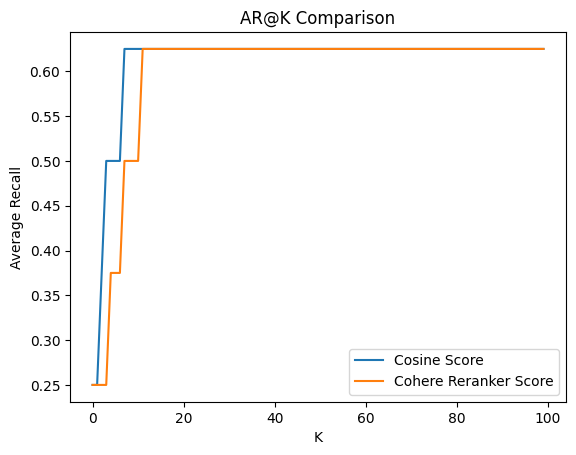

In [158]:
plt.plot(ar_at_k_values_cosine)
plt.plot(ar_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('AR@K Comparison')
plt.xlabel('K')
plt.ylabel('Average Recall')
plt.show()

### Aggregate

In [173]:
# mean average precision
def mean_average_precision(df, score_col, relevance_col='is_relevant'):
    # Calculate AP@K for all queries
    ap_list = []
    for query in df['query'].unique():
        results_subset = df[df['query'] == query]
        ap_values = ap_at_k(results_subset, score_col, relevance_col)
        ap_list.append(ap_values)
    # average AP@K across all queries
    ap_values = np.array(ap_list)
    mean_ap_at_k = np.mean(ap_values, axis=0)
    return mean_ap_at_k

In [163]:
map_at_k_cosine = mean_average_precision(df_query_evals, 'score')
map_at_k_reranker = mean_average_precision(df_query_evals_reranked, 'cohere_score')

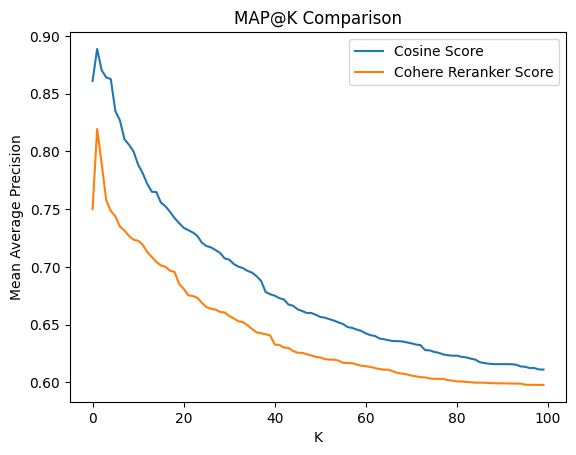

In [164]:
plt.plot(map_at_k_cosine)
plt.plot(map_at_k_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAP@K Comparison')
plt.xlabel('K')
plt.ylabel('Mean Average Precision')
plt.show()

In [174]:
# user queries
df_user_subset = df_query_evals_reranked[df_query_evals_reranked['source']=='user']
map_at_k_cosine_user = mean_average_precision(df_user_subset, 'score')
map_at_k_reranker_user = mean_average_precision(df_user_subset, 'cohere_score')

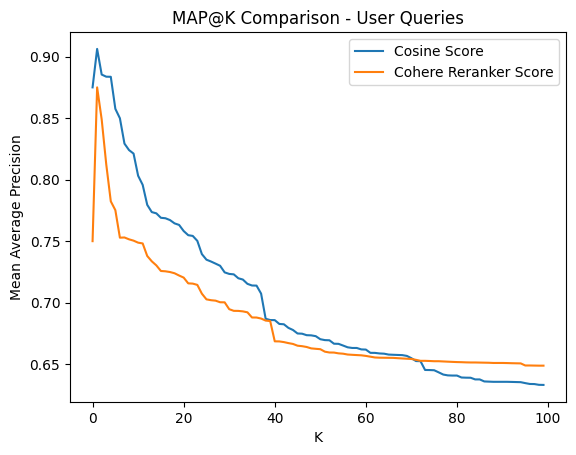

In [175]:
plt.plot(map_at_k_cosine_user)
plt.plot(map_at_k_reranker_user)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAP@K Comparison - User Queries')
plt.xlabel('K')
plt.ylabel('Mean Average Precision')
plt.show()

In [176]:
# user queries
df_synth_subset = df_query_evals_reranked[df_query_evals_reranked['source']=='synth']
map_at_k_cosine_synth = mean_average_precision(df_synth_subset, 'score')
map_at_k_reranker_synth = mean_average_precision(df_synth_subset, 'cohere_score')

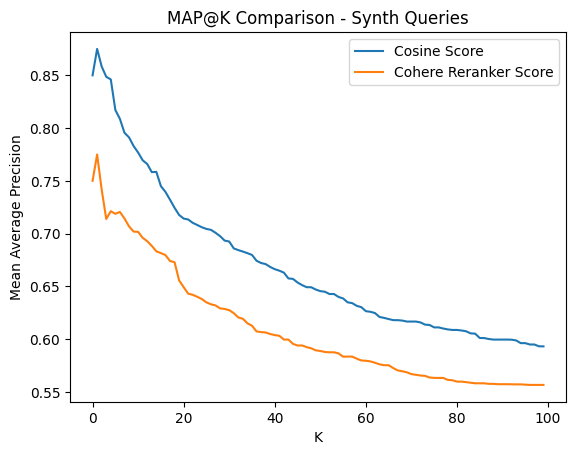

In [177]:
plt.plot(map_at_k_cosine_synth)
plt.plot(map_at_k_reranker_synth)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAP@K Comparison - Synth Queries')
plt.xlabel('K')
plt.ylabel('Mean Average Precision')
plt.show()

In [165]:
# mean average recall
def mean_average_recall(df, score_col, relevance_col='is_relevant'):
    # Calculate AR@K for all queries
    ar_list = []
    for query in all_queries:
        results_subset = df[df['query'] == query]
        ar_values = ar_at_k(results_subset, score_col, relevance_col)
        ar_list.append(ar_values)
    # average AP@K across all queries
    ar_values = np.array(ar_list)
    mean_ar_at_k = np.mean(ar_values, axis=0)
    return mean_ar_at_k

In [166]:
mar_at_k_cosine = mean_average_recall(df_query_evals, 'score')
mar_at_k_reranker = mean_average_recall(df_query_evals_reranked, 'cohere_score')

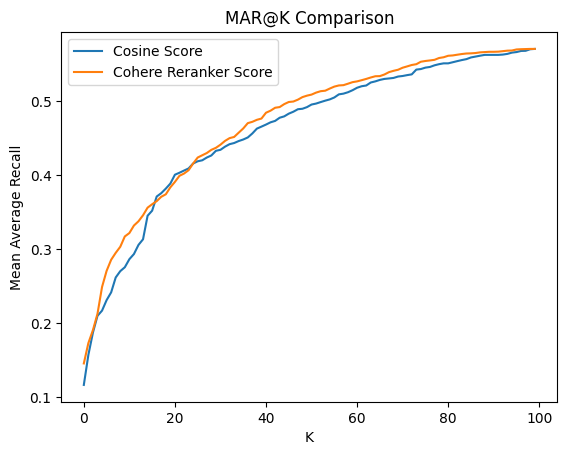

In [167]:
plt.plot(mar_at_k_cosine)
plt.plot(mar_at_k_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAR@K Comparison')
plt.xlabel('K')
plt.ylabel('Mean Average Recall')
plt.show()

## LLM-as-a-Judge -- "Answerability"

In [182]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
import asyncio
from tqdm.asyncio import tqdm

In [183]:

class AnswerabilityEvaluation(BaseModel):
    is_answerable: bool = Field(description="Whether the paragraph helps answer the query")
    reasoning: str = Field(description="Brief explanation of the answerability decision")

In [184]:
answerability_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an expert evaluator determining whether a text paragraph provides useful information to help answer a specific query about world history.

A paragraph is ANSWERABLE/HELPFUL if:
- It contains information that directly answers the question
- It provides essential background, context, or prerequisites needed to understand the answer
- It contains relevant facts, dates, names, or details that contribute to a complete answer
- It addresses key components or aspects of the question, even if not the full answer
- It helps build toward answering the question when combined with other information

A paragraph is NOT ANSWERABLE/HELPFUL if:
- It discusses completely different topics, time periods, people, or regions
- It only has superficial mentions without substantive information
- It provides information that is too general or vague to be useful
- It cannot contribute meaningfully to answering the specific question asked
- It would confuse rather than clarify the answer

Focus on whether the paragraph contains actionable information that would help someone answer the query, not just topical similarity."""
    ),
    (
        "user", 
        """Query: {query}

Paragraph: {paragraph}

Evaluate whether this paragraph helps answer the query by providing useful information.

{format_instructions}"""
    )
])

In [185]:

async def evaluate_answerability(query: str, paragraph: str) -> dict:
    """Evaluate whether a paragraph helps answer a query"""
    parser = JsonOutputParser(pydantic_object=AnswerabilityEvaluation)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)  # Low temp for consistent evaluations
    
    chain = answerability_prompt | llm | parser
    result = await chain.ainvoke({
        "query": query,
        "paragraph": paragraph,
        "format_instructions": parser.get_format_instructions()
    })
    
    return result


In [186]:
from openai import RateLimitError

In [187]:
async def evaluate_answerability_with_retry(query: str, paragraph: str, max_retries=5) -> dict:
    """Evaluate answerability with exponential backoff for rate limits"""
    parser = JsonOutputParser(pydantic_object=AnswerabilityEvaluation)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
    chain = answerability_prompt | llm | parser
    
    for attempt in range(max_retries):
        try:
            result = await chain.ainvoke({
                "query": query,
                "paragraph": paragraph,
                "format_instructions": parser.get_format_instructions()
            })
            return result
        except RateLimitError as e:
            if attempt < max_retries - 1:
                # Exponential backoff: 2^attempt seconds
                wait_time = 2 ** attempt
                print(f"Rate limit hit, waiting {wait_time} seconds before retry {attempt + 1}")
                await asyncio.sleep(wait_time)
            else:
                raise e
        except Exception as e:
            print(f"Unexpected error: {e}")
            if attempt < max_retries - 1:
                await asyncio.sleep(1)
            else:
                raise e

In [202]:

async def evaluate_all_answerability(df, batch_size=50):  # Reduced batch size
    """Evaluate answerability for all rows in the dataframe using batching with rate limit handling"""
    all_results = []
    
    # Process in batches
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        
        # Create tasks for this batch
        tasks = []
        for _, row in batch_df.iterrows():
            task = evaluate_answerability_with_retry(row['query'], row['text'])
            tasks.append(task)
        
        # Run batch concurrently with progress bar
        batch_results = await tqdm.gather(*tasks, desc=f"Evaluating batch {i//batch_size + 1}")
        all_results.extend(batch_results)
        
        # Longer delay between batches to avoid rate limits
        print(f"Completed batch {i//batch_size + 1}, waiting 5 seconds...")
        await asyncio.sleep(5)
    
    # Add results back to dataframe
    df_copy = df.copy()
    for i, result in enumerate(all_results):
        df_copy.loc[df_copy.index[i], 'is_answerable'] = result['is_answerable']
        df_copy.loc[df_copy.index[i], 'answ_reasoning'] = result['reasoning']
    
    return df_copy

In [203]:
# Run the parallel evaluation with batching
df_query_evals_reranked_answ = await evaluate_all_answerability(df_query_evals_reranked)

Evaluating batch 1: 100%|██████████| 50/50 [00:05<00:00,  9.79it/s]



Completed batch 1, waiting 5 seconds...


Evaluating batch 2: 100%|██████████| 50/50 [00:03<00:00, 13.90it/s]



Completed batch 2, waiting 5 seconds...


Evaluating batch 3: 100%|██████████| 50/50 [00:02<00:00, 17.03it/s]



Completed batch 3, waiting 5 seconds...


Evaluating batch 4: 100%|██████████| 50/50 [00:02<00:00, 18.63it/s]



Completed batch 4, waiting 5 seconds...


Evaluating batch 5: 100%|██████████| 50/50 [00:03<00:00, 16.41it/s]



Completed batch 5, waiting 5 seconds...


Evaluating batch 6: 100%|██████████| 50/50 [00:03<00:00, 14.94it/s]



Completed batch 6, waiting 5 seconds...


Evaluating batch 7: 100%|██████████| 50/50 [00:03<00:00, 16.51it/s]



Completed batch 7, waiting 5 seconds...


Evaluating batch 8: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]



Completed batch 8, waiting 5 seconds...


Evaluating batch 9: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]



Completed batch 9, waiting 5 seconds...


Evaluating batch 10: 100%|██████████| 50/50 [00:03<00:00, 15.12it/s]



Completed batch 10, waiting 5 seconds...


Evaluating batch 11: 100%|██████████| 50/50 [00:02<00:00, 18.72it/s]



Completed batch 11, waiting 5 seconds...


Evaluating batch 12: 100%|██████████| 50/50 [00:04<00:00, 12.18it/s]



Completed batch 12, waiting 5 seconds...


Evaluating batch 13: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]



Completed batch 13, waiting 5 seconds...


Evaluating batch 14: 100%|██████████| 50/50 [00:03<00:00, 12.81it/s]



Completed batch 14, waiting 5 seconds...


Evaluating batch 15: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s]



Completed batch 15, waiting 5 seconds...


Evaluating batch 16: 100%|██████████| 50/50 [00:04<00:00, 10.70it/s]



Completed batch 16, waiting 5 seconds...


Evaluating batch 17: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]



Completed batch 17, waiting 5 seconds...


Evaluating batch 18: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s]



Completed batch 18, waiting 5 seconds...


Evaluating batch 19: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]



Completed batch 19, waiting 5 seconds...


Evaluating batch 20: 100%|██████████| 50/50 [00:04<00:00, 11.95it/s]



Completed batch 20, waiting 5 seconds...


Evaluating batch 21: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s]



Completed batch 21, waiting 5 seconds...


Evaluating batch 22: 100%|██████████| 50/50 [00:03<00:00, 12.72it/s]



Completed batch 22, waiting 5 seconds...


Evaluating batch 23: 100%|██████████| 50/50 [00:03<00:00, 16.12it/s]



Completed batch 23, waiting 5 seconds...


Evaluating batch 24: 100%|██████████| 50/50 [00:02<00:00, 17.28it/s]



Completed batch 24, waiting 5 seconds...


Evaluating batch 25: 100%|██████████| 50/50 [00:04<00:00, 11.92it/s]



Completed batch 25, waiting 5 seconds...


Evaluating batch 26: 100%|██████████| 50/50 [00:04<00:00, 10.30it/s]



Completed batch 26, waiting 5 seconds...


Evaluating batch 27: 100%|██████████| 50/50 [00:04<00:00, 10.44it/s]



Completed batch 27, waiting 5 seconds...


Evaluating batch 28: 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]



Completed batch 28, waiting 5 seconds...


Evaluating batch 29: 100%|██████████| 50/50 [00:04<00:00, 10.55it/s]



Completed batch 29, waiting 5 seconds...


Evaluating batch 30: 100%|██████████| 50/50 [00:04<00:00, 12.41it/s]



Completed batch 30, waiting 5 seconds...


Evaluating batch 31: 100%|██████████| 50/50 [00:04<00:00, 11.64it/s]



Completed batch 31, waiting 5 seconds...


Evaluating batch 32: 100%|██████████| 50/50 [00:03<00:00, 14.05it/s]



Completed batch 32, waiting 5 seconds...


Evaluating batch 33: 100%|██████████| 50/50 [00:03<00:00, 15.47it/s]



Completed batch 33, waiting 5 seconds...


Evaluating batch 34: 100%|██████████| 50/50 [00:03<00:00, 16.35it/s]



Completed batch 34, waiting 5 seconds...


Evaluating batch 35: 100%|██████████| 50/50 [00:03<00:00, 12.76it/s]



Completed batch 35, waiting 5 seconds...


Evaluating batch 36: 100%|██████████| 50/50 [00:03<00:00, 14.64it/s]



Completed batch 36, waiting 5 seconds...


Evaluating batch 37: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]



Completed batch 37, waiting 5 seconds...


Evaluating batch 38: 100%|██████████| 50/50 [00:03<00:00, 15.45it/s]



Completed batch 38, waiting 5 seconds...


Evaluating batch 39: 100%|██████████| 50/50 [00:02<00:00, 18.12it/s]



Completed batch 39, waiting 5 seconds...


Evaluating batch 40: 100%|██████████| 50/50 [00:02<00:00, 16.86it/s]



Completed batch 40, waiting 5 seconds...


Evaluating batch 41:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, wait

Evaluating batch 41:  60%|██████    | 30/50 [00:02<00:00, 24.62it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 41:  68%|██████▊   | 34/50 [00:02<00:00, 16.55it/s]

Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3


Evaluating batch 41: 100%|██████████| 50/50 [00:11<00:00,  4.27it/s]



Completed batch 41, waiting 5 seconds...


Evaluating batch 42: 100%|██████████| 50/50 [00:03<00:00, 14.50it/s]



Completed batch 42, waiting 5 seconds...


Evaluating batch 43: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s]



Completed batch 43, waiting 5 seconds...


Evaluating batch 44: 100%|██████████| 50/50 [00:02<00:00, 17.40it/s]



Completed batch 44, waiting 5 seconds...


Evaluating batch 45:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, wait

Evaluating batch 45:   2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 45:  70%|███████   | 35/50 [00:04<00:00, 18.84it/s]

Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3


Evaluating batch 45: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]



Completed batch 45, waiting 5 seconds...


Evaluating batch 46: 100%|██████████| 50/50 [00:03<00:00, 16.14it/s]



Completed batch 46, waiting 5 seconds...


Evaluating batch 47: 100%|██████████| 50/50 [00:03<00:00, 14.35it/s]



Completed batch 47, waiting 5 seconds...


Evaluating batch 48:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, wait

Evaluating batch 48:  54%|█████▍    | 27/50 [00:02<00:00, 23.49it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 48:  62%|██████▏   | 31/50 [00:02<00:01, 18.44it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, wait

Evaluating batch 48: 100%|██████████| 50/50 [00:11<00:00,  4.26it/s]



Completed batch 48, waiting 5 seconds...


Evaluating batch 49: 100%|██████████| 50/50 [00:03<00:00, 13.53it/s]



Completed batch 49, waiting 5 seconds...


Evaluating batch 50: 100%|██████████| 50/50 [00:03<00:00, 15.88it/s]



Completed batch 50, waiting 5 seconds...


Evaluating batch 51: 100%|██████████| 50/50 [00:04<00:00, 10.33it/s]



Completed batch 51, waiting 5 seconds...


Evaluating batch 52:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1


Evaluating batch 52:  90%|█████████ | 45/50 [00:02<00:00, 30.30it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3


Evaluating batch 52: 100%|██████████| 50/50 [00:11<00:00,  4.29it/s]



Completed batch 52, waiting 5 seconds...


Evaluating batch 53: 100%|██████████| 50/50 [00:03<00:00, 13.53it/s]



Completed batch 53, waiting 5 seconds...


Evaluating batch 54: 100%|██████████| 50/50 [00:03<00:00, 16.12it/s]



Completed batch 54, waiting 5 seconds...


Evaluating batch 55: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]



Completed batch 55, waiting 5 seconds...


Evaluating batch 56:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, wait

Evaluating batch 56:   2%|▏         | 1/50 [00:02<01:43,  2.12s/it]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 56:   6%|▌         | 3/50 [00:02<00:33,  1.39it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 56:  10%|█         | 5/50 [00:02<00:19,  2.33it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 56:  18%|█▊        | 9/50 [00:03<00:07,  5.28it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 56:  44%|████▍     | 22/50 [00:04<00:03,  8.91it/s]

Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, wait

Evaluating batch 56: 100%|██████████| 50/50 [00:12<00:00,  4.10it/s]



Completed batch 56, waiting 5 seconds...


Evaluating batch 57: 100%|██████████| 50/50 [00:03<00:00, 15.30it/s]



Completed batch 57, waiting 5 seconds...


Evaluating batch 58: 100%|██████████| 50/50 [00:02<00:00, 17.21it/s]



Completed batch 58, waiting 5 seconds...


Evaluating batch 59:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1


Evaluating batch 59:  62%|██████▏   | 31/50 [00:02<00:00, 27.50it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 59:  76%|███████▌  | 38/50 [00:03<00:01, 11.37it/s]

Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3


Evaluating batch 59: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]



Completed batch 59, waiting 5 seconds...


Evaluating batch 60: 100%|██████████| 50/50 [00:03<00:00, 14.73it/s]



Completed batch 60, waiting 5 seconds...


Evaluating batch 61: 100%|██████████| 50/50 [00:03<00:00, 14.00it/s]



Completed batch 61, waiting 5 seconds...


Evaluating batch 62: 100%|██████████| 50/50 [00:04<00:00, 10.25it/s]



Completed batch 62, waiting 5 seconds...


Evaluating batch 63: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]



Completed batch 63, waiting 5 seconds...


Evaluating batch 64:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1


Evaluating batch 64:  46%|████▌     | 23/50 [00:02<00:01, 17.74it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 64:  52%|█████▏    | 26/50 [00:02<00:01, 17.32it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2


Evaluating batch 64:  76%|███████▌  | 38/50 [00:04<00:01,  6.50it/s]

Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3


Evaluating batch 64: 100%|██████████| 50/50 [00:14<00:00,  3.51it/s]



Completed batch 64, waiting 5 seconds...


Evaluating batch 65: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]



Completed batch 65, waiting 5 seconds...


Evaluating batch 66: 100%|██████████| 50/50 [00:05<00:00, 10.00it/s]



Completed batch 66, waiting 5 seconds...


Evaluating batch 67: 100%|██████████| 50/50 [00:05<00:00,  8.40it/s]



Completed batch 67, waiting 5 seconds...


Evaluating batch 68: 100%|██████████| 50/50 [00:05<00:00,  9.90it/s]



Completed batch 68, waiting 5 seconds...


Evaluating batch 69: 100%|██████████| 50/50 [00:05<00:00,  9.09it/s]



Completed batch 69, waiting 5 seconds...


Evaluating batch 70: 100%|██████████| 50/50 [00:04<00:00, 10.06it/s]



Completed batch 70, waiting 5 seconds...


Evaluating batch 71: 100%|██████████| 50/50 [00:06<00:00,  7.68it/s]



Completed batch 71, waiting 5 seconds...


Evaluating batch 72: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]



Completed batch 72, waiting 5 seconds...


In [206]:
print(df_query_evals_reranked_answ.iloc[200]['answ_reasoning'])

The paragraph does not provide a clear definition of 'barbarians' as requested in the query. Instead, it discusses the interactions between wandering peoples and established civilizations, without explicitly defining what constitutes a barbarian.


In [242]:
df_query_evals_reranked_answ["is_answerable"] = df_query_evals_reranked_answ["is_answerable"].astype(np.bool)

In [243]:
df_query_evals_reranked_answ.to_csv("retrieval_reranked_answerability_evals.csv", index=False)

### Spot checks

In [244]:
from history_book.utils.utils import print_with_wrapping

In [245]:
# sample n random indices
n = 10
test_inds = np.random.randint(0, len(df_query_evals_reranked_answ)-1, size=n)
print(test_inds)

[2244 2817 2637   55 2845  701 1182  369 1487 2182]


In [246]:
df_query_evals_reranked_answ.head(5)

,query,text,score,is_relevant,reasoning,source,cohere_score,is_answerable,answ_reasoning
0,What were the first civilizations?,Somewhere in the fourth millennium BC is the s...,0.620501,True,The paragraph provides a chronological overvie...,user,0.980803,True,The paragraph provides a chronological overvie...
1,What were the first civilizations?,About these first civilizations (whose appeara...,0.594695,True,The paragraph discusses the characteristics an...,user,0.992879,False,The paragraph discusses the characteristics an...
2,What were the first civilizations?,Mesopotamia was not the only great river valle...,0.593171,True,"The paragraph discusses Mesopotamia and Egypt,...",user,0.918334,True,The paragraph discusses Mesopotamia and Egypt ...
3,What were the first civilizations?,Some of these early civilizations are still re...,0.590554,True,The paragraph discusses early civilizations an...,user,0.947381,False,The paragraph discusses the influence of early...
4,What were the first civilizations?,The best case for the first appearance of some...,0.587494,True,The paragraph discusses the emergence of civil...,user,0.943034,True,The paragraph provides specific information ab...


In [247]:
for i in test_inds:
    row = df_query_evals_reranked_answ.iloc[i]
    print_with_wrapping(f"query:\n{row['query']}\n\ntext:\n{row['text']}\nrerank_score: {row['cohere_score']}\n\nis_answerable: {row['is_answerable']}\nreasoning:\n{row['answ_reasoning']}\n")
    print("\n" + "="*80 + "\n")

query:
How did the Opium Wars between Britain and China alter the course of modern
Chinese history?
text:
The United States became increasingly disillusioned by the revealed inadequacy
and corruption of Chiang Kai-shek’s government. In 1947 American forces were
withdrawn from China, and the United States abandoned all efforts to mediate in
the civil war. In the following year, with most of the north in Communist hands,
the Americans began to cut down the amount of financial and military aid given
to the Guomindang. From this time on, the nationalist government ran militarily
and politically downhill; as this became obvious, more and more employees of the
government and local authorities sought to make terms with the Communists while
they might still do so. The conviction spread that a new era was dawning. By the
beginning of December, no important Guomindang military force remained intact on
the mainland and Chiang withdrew to Taiwan. The Americans cut off their aid
while this withdraw

## Analysis - answerability

### Single Query

In [388]:
query = all_queries[20]
query

'How did the Industrial Revolution transform economic systems in Europe and North America?'

In [389]:
results_subset = df_query_evals_reranked_answ[df_query_evals_reranked_answ['query'] == query]

In [390]:
results_subset_sorted = results_subset.sort_values(by='cohere_score', ascending=False)

In [391]:
for i, row in results_subset_sorted.head(20).iterrows():
    print_with_wrapping(f"query:\n{row['query']}\n\ntext:\n{row['text']}\nrerank_score: {row['cohere_score']}\n\nis_answerable: {row['is_answerable']}\nreasoning:\n{row['answ_reasoning']}\n")
    print("\n" + "="*80 + "\n")

query:
How did the Industrial Revolution transform economic systems in Europe and North
America?
text:
Both of these changes were aspects of a single process, the accelerating
investment in productive capacity which made Europe and North America by 1870
clearly the greatest concentration of wealth on the face of the globe.
Agriculture was fundamental to it. People have spoken of an ‘agricultural
revolution’ and provided this is not thought of as implying rapid change, it is
an acceptable term; nothing much less strong will describe the huge surge in
world output achieved between 1750 and 1870 (and, later, even surpassed). But it
was a process of great complexity, drawing on many different sources and linked
to the other sectors of the economy in indispensable ways. It was only one
aspect of a worldwide economic change which involved in the end not merely
continental Europe, but the Americas and Australasia as well.
rerank_score: 0.33654907
is_answerable: True
reasoning:
The paragraph d

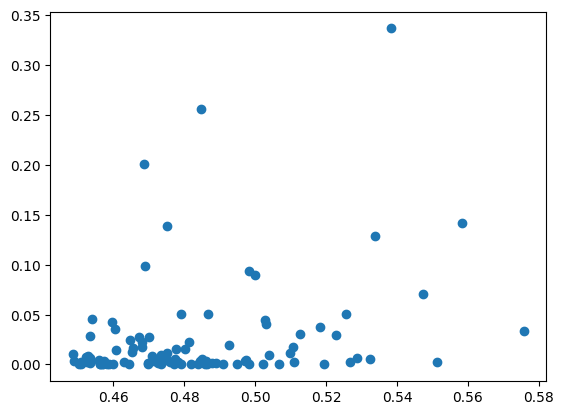

In [392]:
plt.scatter(results_subset['score'], results_subset['cohere_score'])

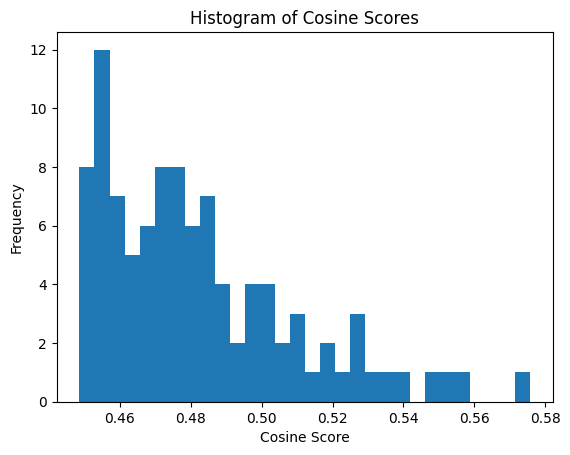

In [393]:
plt.hist(results_subset['score'], bins=30)
plt.title('Histogram of Cosine Scores')
plt.xlabel('Cosine Score')
plt.ylabel('Frequency')
plt.show()

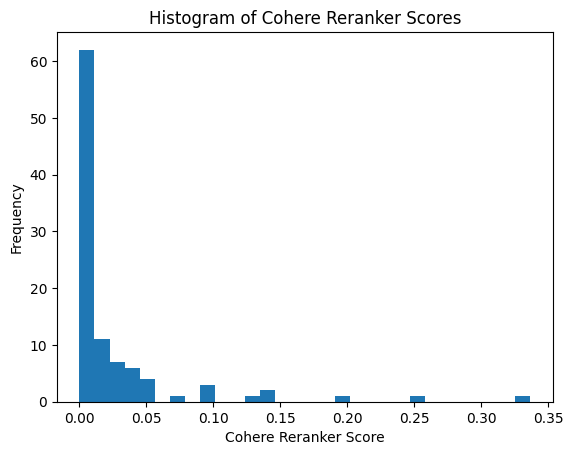

In [394]:
plt.hist(results_subset['cohere_score'], bins=30)
plt.title('Histogram of Cohere Reranker Scores')
plt.xlabel('Cohere Reranker Score')
plt.ylabel('Frequency')
plt.show()

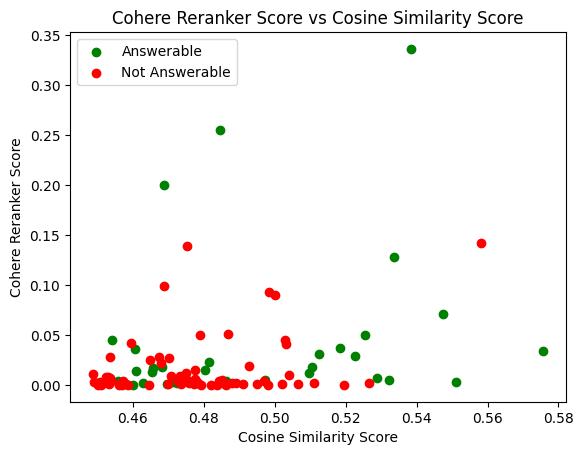

In [395]:
res_is_relevant = results_subset[results_subset['is_answerable']]
res_not_relevant = results_subset[~results_subset['is_answerable']]
plt.scatter(res_is_relevant['score'], res_is_relevant['cohere_score'], color='green', label='Answerable')
plt.scatter(res_not_relevant['score'], res_not_relevant['cohere_score'], color='red', label='Not Answerable')
plt.legend()
plt.title('Cohere Reranker Score vs Cosine Similarity Score')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Cohere Reranker Score')
plt.show()

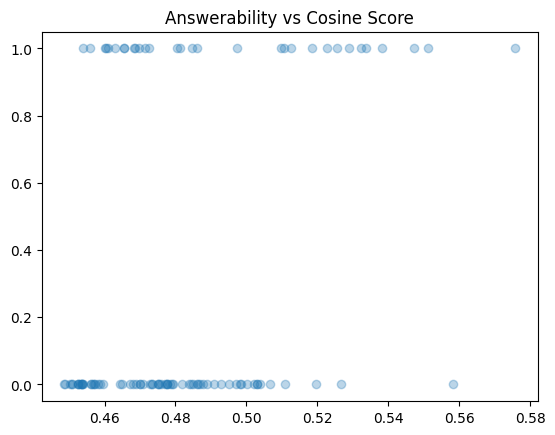

In [396]:
plt.scatter(results_subset['score'], results_subset['is_answerable'], alpha=0.3)
plt.title('Answerability vs Cosine Score')
plt.show()

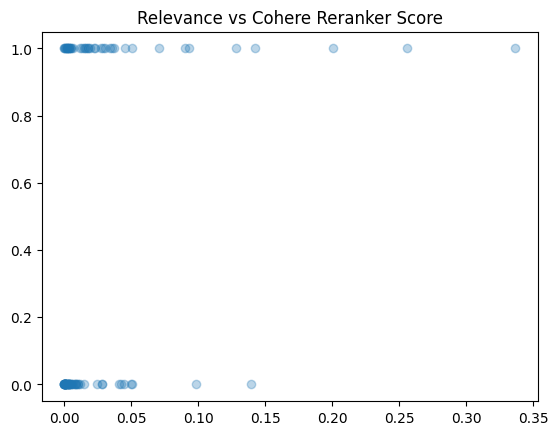

In [397]:
plt.scatter(results_subset['cohere_score'], results_subset['is_relevant'], alpha=0.3)
plt.title('Relevance vs Cohere Reranker Score')
plt.show()

In [398]:
def precision_at_k(df, score_col, relevance_col='is_relevant'):
    precision_values = []
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k)
        precision = df_sorted[relevance_col].mean()
        precision_values.append(precision)
    return precision_values

In [399]:
precision_at_k_values_cosine = precision_at_k(results_subset, 'score', 'is_answerable')
precision_at_k_values_reranker = precision_at_k(results_subset, 'cohere_score', "is_answerable")

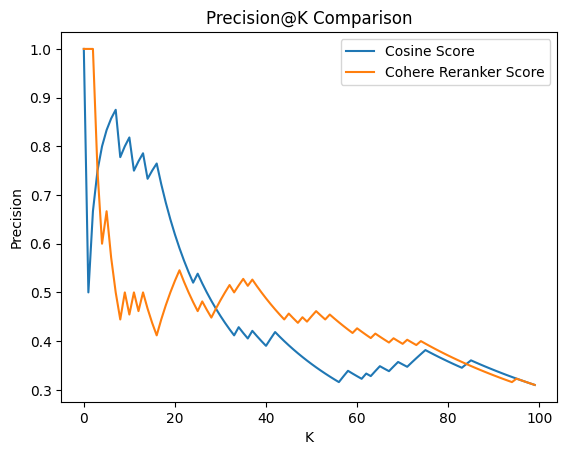

In [400]:
plt.plot(precision_at_k_values_cosine)
plt.plot(precision_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('Precision@K Comparison')
plt.xlabel('K')
plt.ylabel('Precision')
plt.show()

In [401]:
# average precision at k
def ap_at_k(df, score_col, relevance_col='is_relevant'):
    # start with p@k
    precision_values = precision_at_k(df, score_col, relevance_col)
    ap_values = []
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k).reset_index(drop=True)
        relevant_indices = df_sorted.index[df_sorted[relevance_col] == True].tolist()
        if len(relevant_indices) == 0:
            ap_values.append(0)
            continue
        ap = 0
        for idx in relevant_indices:
            ap += precision_values[idx]  # precision at the rank of this relevant document
        ap /= len(relevant_indices)  # average over all relevant documents
        ap_values.append(ap)
    return ap_values    

In [402]:
ap_at_k_values_cosine = ap_at_k(results_subset, 'score', "is_answerable")
ap_at_k_values_reranker = ap_at_k(results_subset, 'cohere_score', "is_answerable")

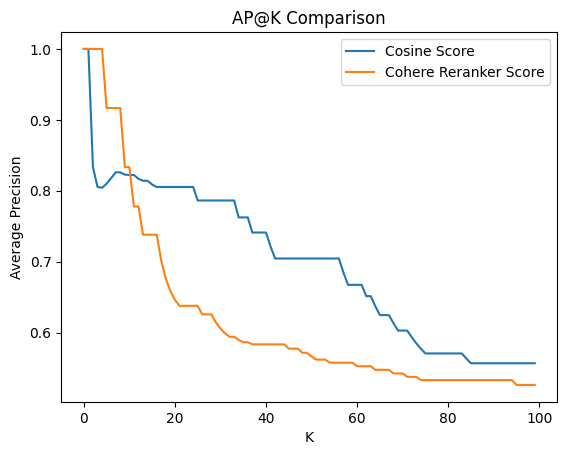

In [403]:
plt.plot(ap_at_k_values_cosine)
plt.plot(ap_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('AP@K Comparison')
plt.xlabel('K')
plt.ylabel('Average Precision')
plt.show()

In [404]:
def recall_at_k(df, score_col, relevance_col='is_relevant'):
    recall_values = []
    total_relevant = df[relevance_col].sum()
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k)
        recall = df_sorted[relevance_col].sum() / total_relevant if total_relevant > 0 else 0
        recall_values.append(recall)
    return recall_values

In [405]:
recall_at_k_values_cosine = recall_at_k(results_subset, 'score', "is_answerable")
recall_at_k_values_reranker = recall_at_k(results_subset, 'cohere_score', "is_answerable")

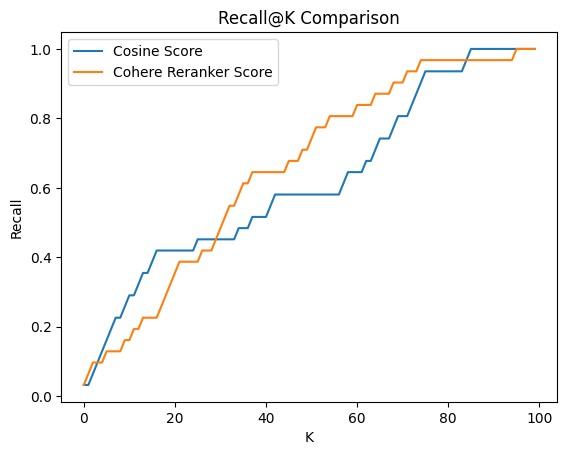

In [406]:
plt.plot(recall_at_k_values_cosine)
plt.plot(recall_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('Recall@K Comparison')
plt.xlabel('K')
plt.ylabel('Recall')
plt.show()

In [407]:
# average recall at k
def ar_at_k(df, score_col, relevance_col='is_relevant'):
    # start with r@k
    recall_values = recall_at_k(df, score_col, relevance_col)
    ar_values = []
    for k in range(1, len(df)+1):
        df_sorted = df.sort_values(by=score_col, ascending=False).head(k).reset_index(drop=True)
        relevant_indices = df_sorted.index[df_sorted[relevance_col] == True].tolist()
        if len(relevant_indices) == 0:
            ar_values.append(0)
            continue
        ar = 0
        for idx in relevant_indices:
            ar += recall_values[idx]  # recall at the rank of this relevant document
        ar /= len(relevant_indices)  # average over all relevant documents
        ar_values.append(ar)
    return ar_values    

In [408]:
ar_at_k_values_cosine = ar_at_k(results_subset, 'score', 'is_answerable')
ar_at_k_values_reranker = ar_at_k(results_subset, 'cohere_score', 'is_answerable')

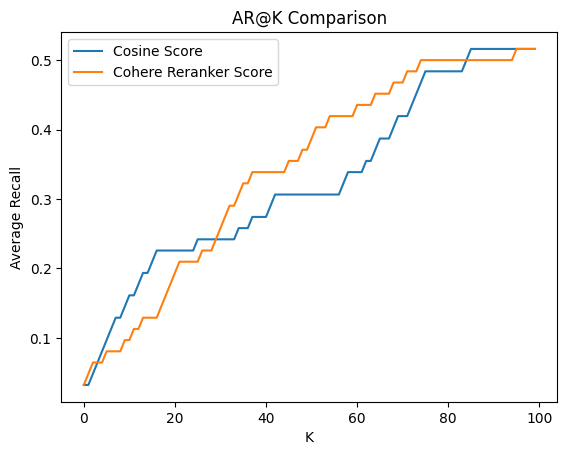

In [409]:
plt.plot(ar_at_k_values_cosine)
plt.plot(ar_at_k_values_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('AR@K Comparison')
plt.xlabel('K')
plt.ylabel('Average Recall')
plt.show()

### Aggregate

In [343]:
# mean average precision
def mean_average_precision(df, score_col, relevance_col='is_relevant'):
    # Calculate AP@K for all queries
    ap_list = []
    for query in df['query'].unique():
        results_subset = df[df['query'] == query]
        ap_values = ap_at_k(results_subset, score_col, relevance_col)
        ap_list.append(ap_values)
    # average AP@K across all queries
    ap_values = np.array(ap_list)
    mean_ap_at_k = np.mean(ap_values, axis=0)
    return mean_ap_at_k

In [346]:
map_at_k_cosine = mean_average_precision(df_query_evals_reranked_answ, 'score', 'is_answerable')
map_at_k_reranker = mean_average_precision(df_query_evals_reranked_answ, 'cohere_score', 'is_answerable')

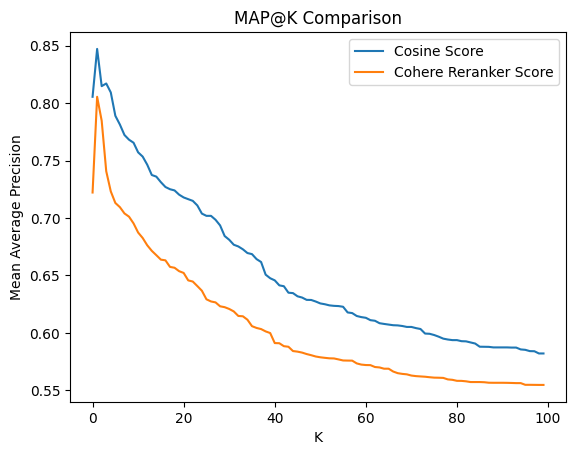

In [348]:
plt.plot(map_at_k_cosine)
plt.plot(map_at_k_reranker)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAP@K Comparison')
plt.xlabel('K')
plt.ylabel('Mean Average Precision')
plt.show()

In [349]:
# user queries
df_user_subset = df_query_evals_reranked_answ[df_query_evals_reranked_answ['source']=='user']
map_at_k_cosine_user = mean_average_precision(df_user_subset, 'score', 'is_answerable')
map_at_k_reranker_user = mean_average_precision(df_user_subset, 'cohere_score', 'is_answerable')

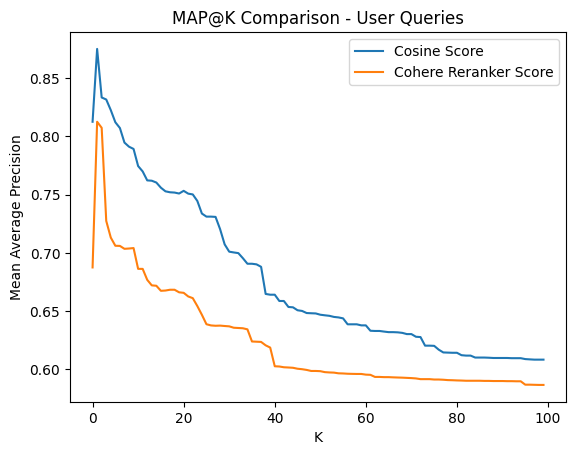

In [350]:
plt.plot(map_at_k_cosine_user)
plt.plot(map_at_k_reranker_user)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAP@K Comparison - User Queries')
plt.xlabel('K')
plt.ylabel('Mean Average Precision')
plt.show()

In [351]:
# synth queries
df_synth_subset = df_query_evals_reranked_answ[df_query_evals_reranked_answ['source']=='synth']
map_at_k_cosine_synth = mean_average_precision(df_synth_subset, 'score', 'is_answerable')
map_at_k_reranker_synth = mean_average_precision(df_synth_subset, 'cohere_score', 'is_answerable')

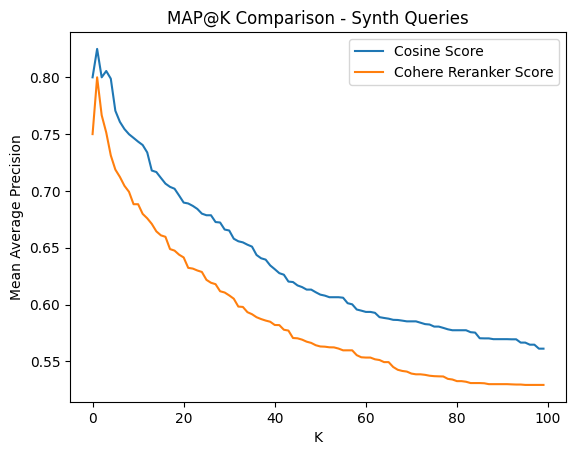

In [352]:
plt.plot(map_at_k_cosine_synth)
plt.plot(map_at_k_reranker_synth)
plt.legend(['Cosine Score', 'Cohere Reranker Score'])
plt.title('MAP@K Comparison - Synth Queries')
plt.xlabel('K')
plt.ylabel('Mean Average Precision')
plt.show()

### NDCG

In [371]:
from sklearn.metrics import ndcg_score

In [410]:
ndcg_scores_cosine = []
ndcg_scores_reranker = []
for k in range(1, len(results_subset)+1):
    ndcg_cosine = ndcg_score(results_subset[['is_answerable']].T, results_subset[['score']].T, k=k)
    ndcg_reranker = ndcg_score(results_subset[['is_answerable']].T, results_subset[['cohere_score']].T, k=k)
    ndcg_scores_cosine.append(ndcg_cosine)
    ndcg_scores_reranker.append(ndcg_reranker)

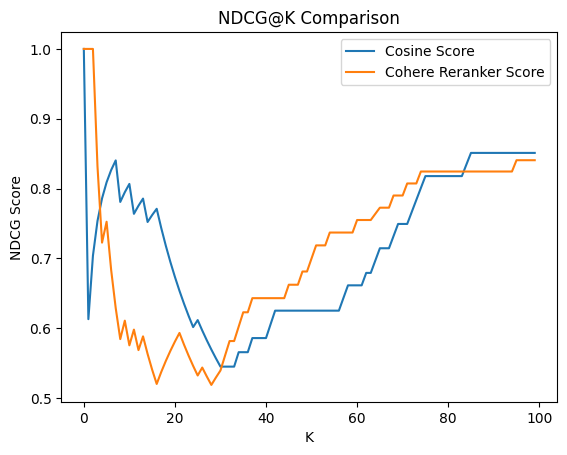

In [411]:
plt.plot(ndcg_scores_cosine, label='Cosine Score')
plt.plot(ndcg_scores_reranker, label='Cohere Reranker Score')
plt.legend()
plt.title('NDCG@K Comparison')
plt.xlabel('K')
plt.ylabel('NDCG Score')
plt.show()